 # Recommender System

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set(style="white")

In [6]:
rating_columns = ['user_id', 'item_id', 'rating', 'timestamp']

ratings = pd.read_csv('u.data', sep='\t', names=rating_columns)

ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [8]:
print(ratings.shape)

(100000, 4)


In [9]:
# Checking for the null values
ratings.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

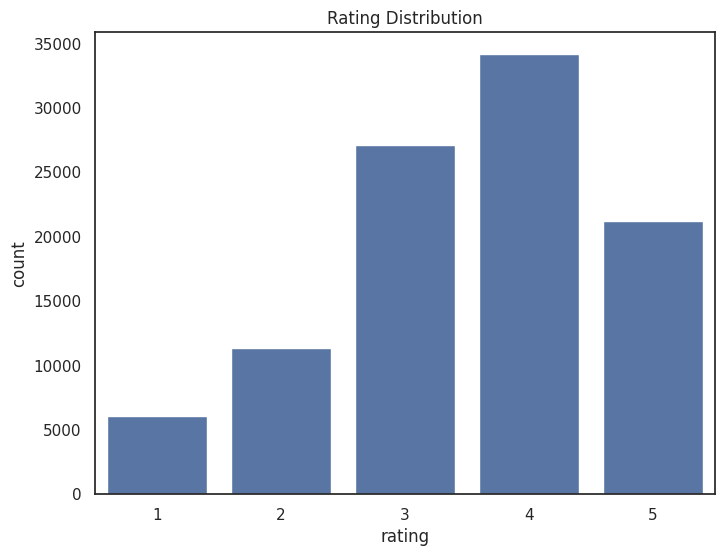

In [10]:
# Analysis of rating distribution
plt.figure(figsize=(8,6))
sns.countplot(x='rating',data=ratings)
plt.title('Rating Distribution')

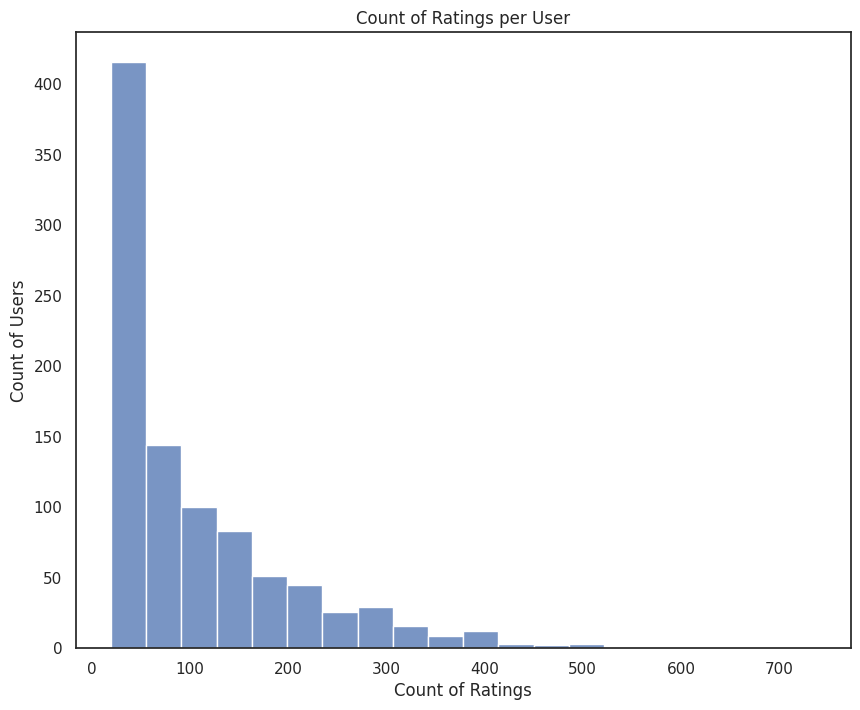

In [11]:
# Rating per user
rating_per_user=ratings.groupby('user_id').size()
plt.figure(figsize=(10,8))
sns.histplot(rating_per_user,bins=20,kde=False)
plt.title('Count of Ratings per User')
plt.xlabel('Count of Ratings')
plt.ylabel('Count of Users')
plt.show()

In [12]:
# Calculation of the sparsity (emptiness) in the data set

num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
total_possible_ratings = num_users * num_items
sparsity = 1 - len(ratings) / total_possible_ratings
print(f"Sparsity of the dataset: {sparsity:.2%}")     #Most users did not rate most movies as Sparsity is high

Sparsity of the dataset: 93.70%


In [13]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('u.item', sep='|', names=movie_columns, encoding='latin-1')
movies[['movie_id', 'title']].head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [14]:
# Merging two tables
data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')
data[['user_id', 'title', 'rating']].head()

,user_id,title,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


In [15]:
# Create user-movie matrix  (for displaying final recommendations with titles)
user_movie_matrix = data.pivot_table(index='user_id', columns='title', values='rating')

In [16]:
# For calculations and modeling
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

In [17]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Step 1: Load your ratings data
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# Step 2: Split into train and test set
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Step 3: Use SVD (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

# Step 4: Predict ratings on the test set
predictions = model.test(testset)

# Step 5: Evaluate the model
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

RMSE: 0.9370
RMSE: 0.936970806766718
MAE:  0.7380
MAE: 0.7380226048513283


In [18]:
print(f"Number of training ratings: {trainset.n_ratings}")
print(f"Number of test ratings: {len(testset)}")

Number of training ratings: 80000
Number of test ratings: 20000


In [19]:
# Filter users with more than 100 ratings
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts > 100].index
filtered_data = data[data['user_id'].isin(active_users)]

# Filter movies with more than 50 ratings
movie_counts = filtered_data['title'].value_counts()
popular_movies = movie_counts[movie_counts > 50].index
filtered_data = filtered_data[filtered_data['title'].isin(popular_movies)]


In [20]:
filtered_matrix = filtered_data.pivot_table(index='user_id', columns='title', values='rating')

In [21]:
# Choose your target movie

target_movie = 'Star Wars (1977)'

# Check if the movie exists in your filtered matrix
if target_movie in filtered_matrix.columns:
    # Get all the user ratings for this movie
    movie_ratings = filtered_matrix[target_movie]

    # Compute correlations between 'Star Wars (1977)' and every other movie
    similar_movies = filtered_matrix.corrwith(movie_ratings)

    # Create a DataFrame for easy sorting and filtering
    corr_df = similar_movies.to_frame(name='Correlation').dropna()

    # Add the number of ratings for each movie for reliability
    rating_counts = filtered_data.groupby('title')['rating'].count()
    corr_df = corr_df.join(rating_counts)

    # Filter for movies with a minimum number of ratings, then sort by correlation
    recommendations = corr_df[corr_df['rating'] > 50].sort_values('Correlation', ascending=False)

    print("Top recommendations based on 'Star Wars (1977)':")
    print(recommendations.head(10))
else:
    print(f"'{target_movie}' not found in the filtered matrix.")


Top recommendations based on 'Star Wars (1977)':
                                                    Correlation  rating
title                                                                  
Star Wars (1977)                                       1.000000     328
Empire Strikes Back, The (1980)                        0.734640     271
Return of the Jedi (1983)                              0.682426     301
Raiders of the Lost Ark (1981)                         0.494209     306
Things to Do in Denver when You're Dead (1995)         0.395455      54
Frighteners, The (1996)                                0.393774      87
Austin Powers: International Man of Mystery (1997)     0.391133      94
Spitfire Grill, The (1996)                             0.360801      57
L.A. Confidential (1997)                               0.360655     121
Sting, The (1973)                                      0.360203     178
